In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from molecular_mpns.config import fig_dir
import os

os.chdir(fig_dir)

In [2]:
# define gaussian mixture
class GM:
    
    def __init__(self,centers,sds,weights):
        self.centers = centers
        self.sds = sds
        self.weights = weights
        
    
    def sample(self,n):
    
        centers_idx,dim = self.centers.shape
        samps = np.zeros((n,dim))
        random_idx = np.random.choice(a = centers_idx,size = n, replace = True, p = self.weights)
        
        for i,idx in enumerate(random_idx):
            mu,sig = self.centers[idx],self.sds[idx]
            samp = np.random.multivariate_normal(mean = mu, cov = (sig**2)*np.eye(dim),size = 1)
            samps[i] = samp
            
        return samps

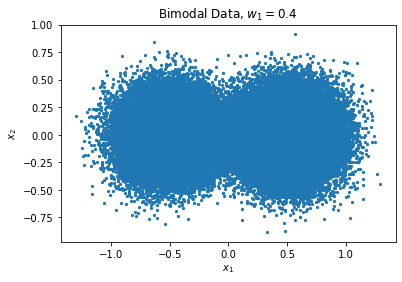

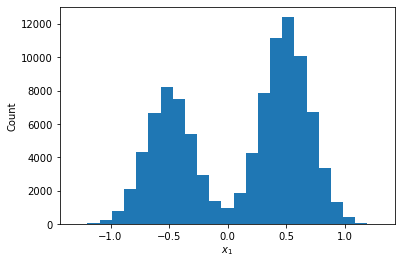

In [3]:
# simulate training trajectory
N = 100000

w1 = 0.4
w2 = 1 - w1
y = 0
x1,x2 = -0.5,0.5
s1,s2 = 0.2,0.2

centers,sds,weights = np.array([[x1,y],[x2,y]]),np.array([s1,s2]),np.array([w1,w2])
system = GM(centers,sds,weights)

np.random.seed(42)
train_traj = system.sample(N)
    
plt.scatter(train_traj[:,0],train_traj[:,1],s = 5)
plt.title('Bimodal Data, ' + '$w_1 = $' + str(w1))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('eq_bimodal_data.png')
plt.show()
plt.close()

plt.hist(train_traj[:,0],bins = 25,density = False)
plt.xlabel('$x_1$')
plt.ylabel('Count')
plt.savefig('eq_bimodal_datax1.png')
plt.show()
plt.close()

In [4]:
# create train/test split and data loader
X = train_traj
X_first,X_last = X[0:int(N/4)],X[int(N/4):]

N_train,N_val = 20000,20000
X_train, X_val = X_first[np.random.choice(X_first.shape[0],N_train)], X_last[np.random.choice(X_last.shape[0],N_val)]
X_train,X_val = torch.tensor(X_train),torch.tensor(X_val)

batch_size = 32
training_dataset = TensorDataset(X_train)
training_loader = DataLoader(training_dataset,batch_size = batch_size)

In [5]:
# define model

class VAE(torch.nn.Module):
    
    def __init__(self,xdim=2,zdim=1,training = True):
        
        super(VAE,self).__init__()
        
        d1,d2,d3 = 256,256,256 # hidden dimensions in network
        self.training = training
        self.xdim = xdim
        
        # encoder
        self.enc_lin1 = torch.nn.Linear(xdim,d1)
        self.enc_lin2 = torch.nn.Linear(d1,d2)
        self.enc_lin3 = torch.nn.Linear(d2,d3)
        
        self.enc_mu = torch.nn.Linear(d3,zdim)
        self.enc_logvar = torch.nn.Linear(d3,zdim)
    
        # decoder
        self.dec_lin1 = torch.nn.Linear(zdim,d1)
        self.dec_lin2 = torch.nn.Linear(d1,d2)
        
        #self.dec_logvar = torch.nn.Parameter(torch.zeros(xdim), requires_grad=True)
        self.dec_logvar = torch.nn.Linear(d2,xdim)
        self.dec_mu = torch.nn.Linear(d2,xdim)
        
    def encode(self,x):
        
        h = self.enc_lin1(x)
        h = torch.nn.functional.selu(h)
        h = self.enc_lin2(h)
        h = torch.nn.functional.selu(h)
        h = self.enc_lin3(h)
        h = torch.tanh(h)
        
        mu_enc = self.enc_mu(h)
        logvar_enc = self.enc_logvar(h)
        
        return mu_enc, logvar_enc
    
    def reparameterize(self,mu_enc,mu_logvar):
        
        sigma = torch.exp(0.5*mu_logvar)
        eps = torch.randn_like(sigma)
        z = mu_enc + (sigma*eps)
        
        return z if self.training else mu_enc
    
    def decode(self,z):
        
        h = self.dec_lin1(z)
        h = torch.tanh(h)
        h = self.dec_lin2(h)
        h = torch.tanh(h)
        
        mu_dec = self.dec_mu(h)
        
        #batch_size = mu_dec.shape[0]
        #logvar_dec = self.dec_logvar.repeat(batch_size, 1)
        logvar_dec = self.dec_logvar(h)
        
        return mu_dec, logvar_dec
    
    def forward(self, x):
        mu_enc, logvar_enc = self.encode(x.view(-1, self.xdim))
        z = self.reparameterize(mu_enc, logvar_enc)
        return self.decode(z), mu_enc, logvar_enc
    
def VAEloss(mu_dec,logvar_dec,x,mu_enc,logvar_enc,L,xdim = 2):
    
    # recon loss for p(x | z)
    pointwiseMSEloss = 0.5*torch.nn.functional.mse_loss(mu_dec,x.view(-1,xdim),reduction = 'none')
    sigsq = torch.exp(logvar_dec)
    weight = 1/sigsq
    pointwiseWeightedMSEloss = pointwiseMSEloss*weight
    WeightedMSEloss = pointwiseWeightedMSEloss.sum()
    
    logvarobjective = 0.5 * logvar_dec.sum() # scaling factor term for p(x|z)
    
    # KLD loss for q(z | x)
    KLD = -0.5 * torch.sum(1 + logvar_enc - mu_enc**2 - torch.exp(logvar_enc))
    
    loss = (KLD + (1/L)*WeightedMSEloss + logvarobjective)
    
    return loss

<ipython-input-6-57c67386a08c>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(dataaug).to(device)


Epoch 1 Loss: -1723066301.685172


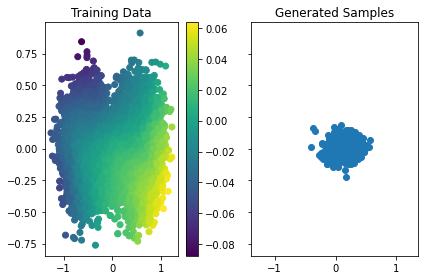

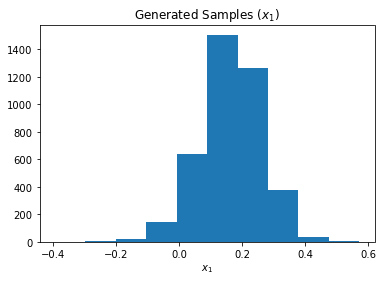

Epoch 2 Loss: -1873905835.1065934


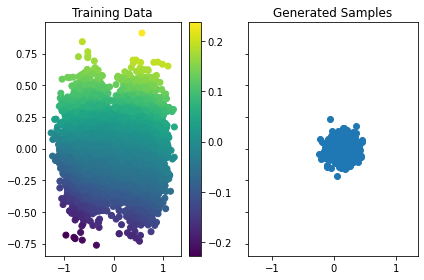

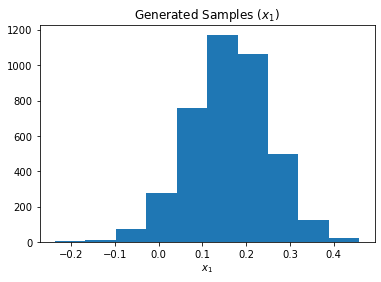

Epoch 3 Loss: -1879717221.1271253


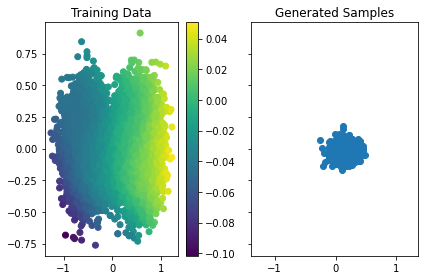

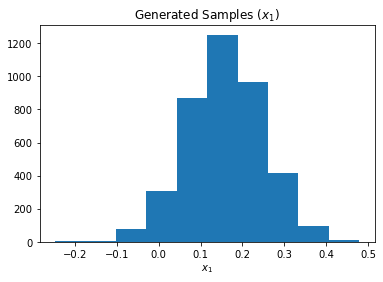

Epoch 4 Loss: -1881578212.2089393


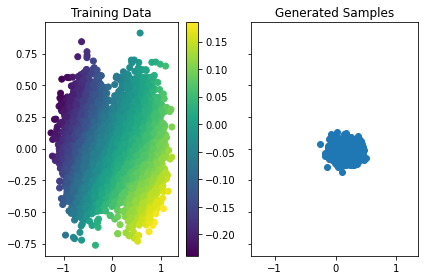

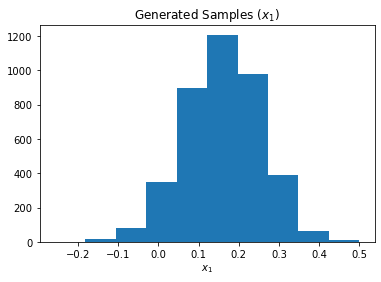

Epoch 5 Loss: -1882223732.7619114


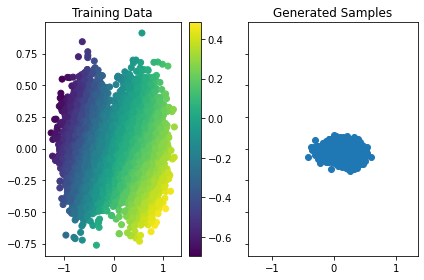

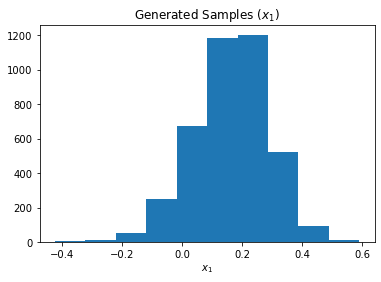

Epoch 6 Loss: -1919785608.5964608


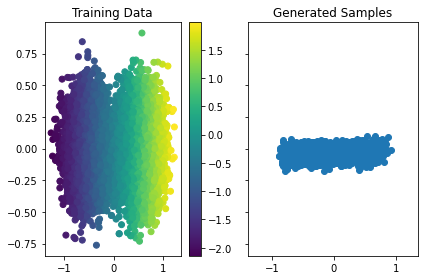

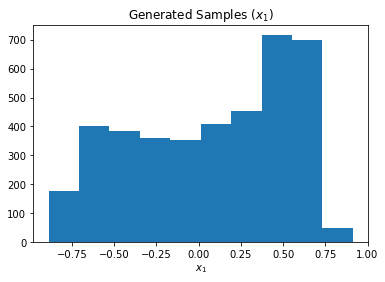

Epoch 7 Loss: -1967521361.1808937


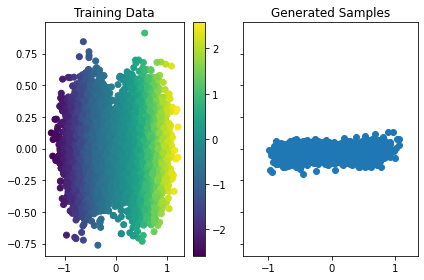

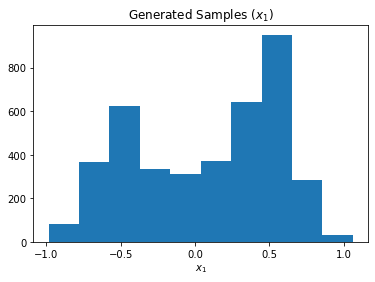

Epoch 8 Loss: -1977503917.1250234


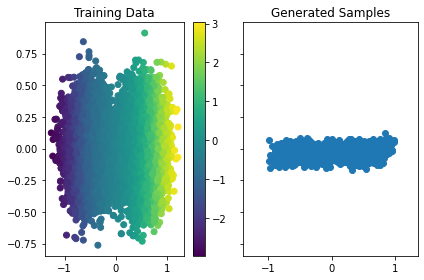

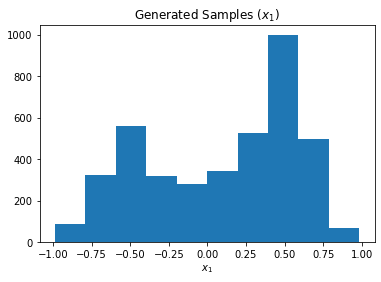

Epoch 9 Loss: -1983635911.5972126


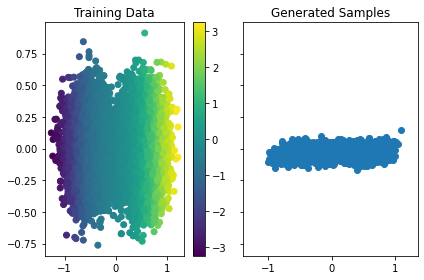

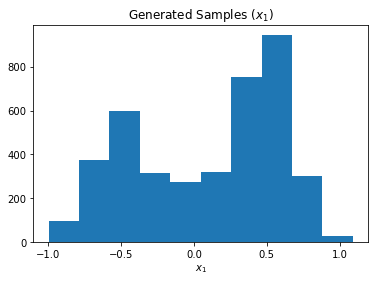

Epoch 10 Loss: -1989271941.7775302


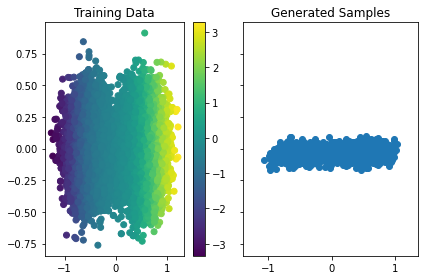

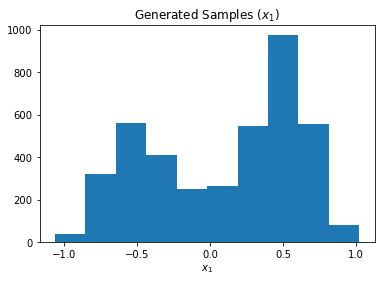

Epoch 11 Loss: -1992406951.8420963


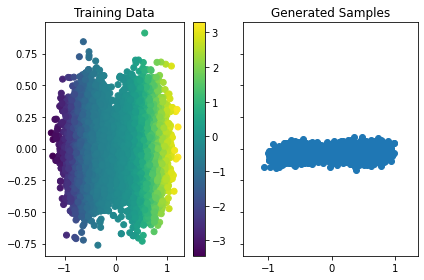

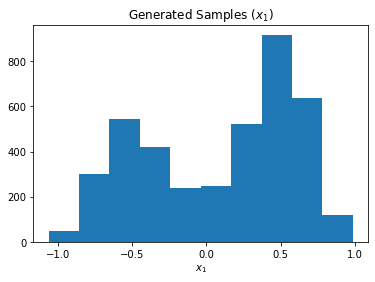

Epoch 12 Loss: -1994475094.1878169


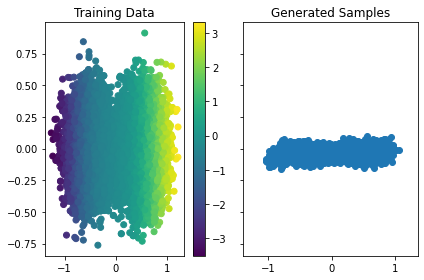

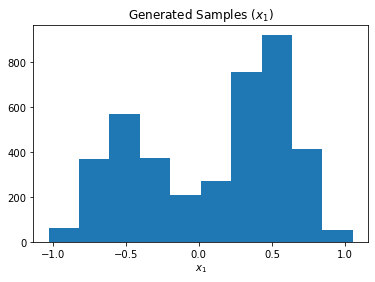

Epoch 13 Loss: -1996499062.9568653


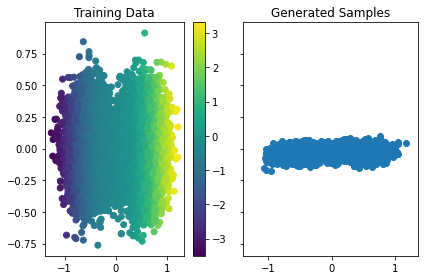

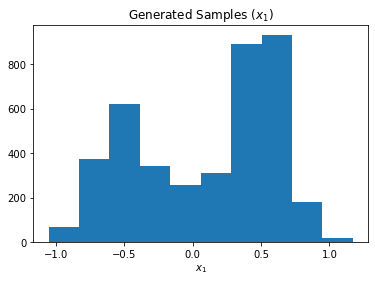

Epoch 14 Loss: -1997772159.0145721


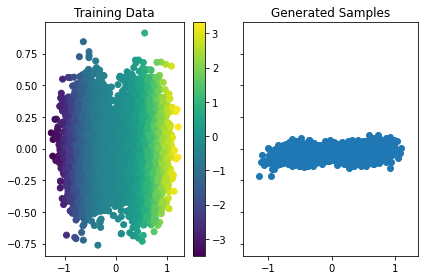

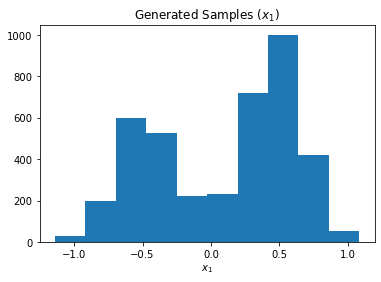

Epoch 15 Loss: -1997889495.4592907


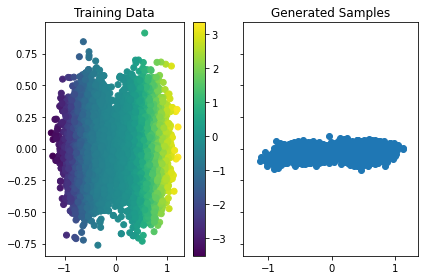

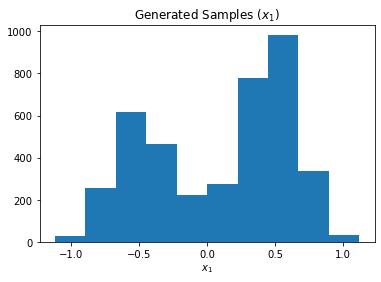

Epoch 16 Loss: -1999350291.8965282


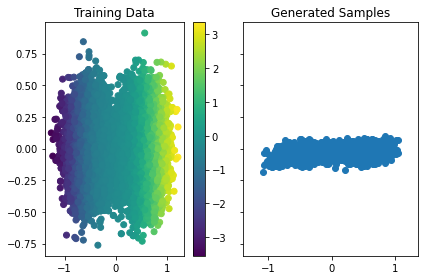

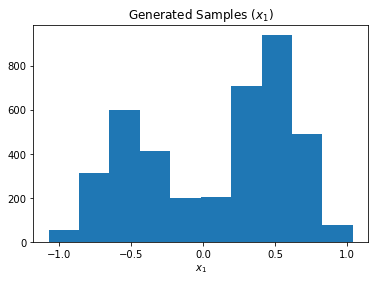

Epoch 17 Loss: -1999707815.9316442


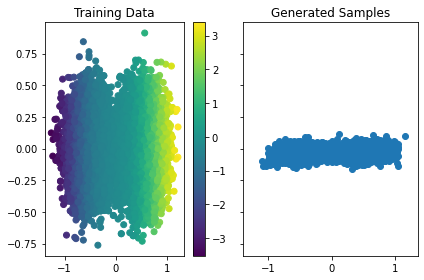

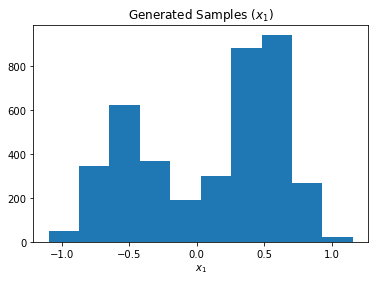

Epoch 18 Loss: -1999911845.0815747


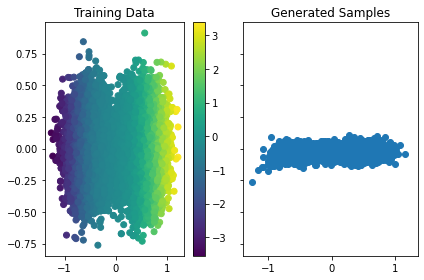

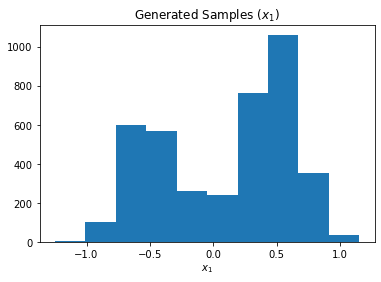

Epoch 19 Loss: -2001246829.9954717


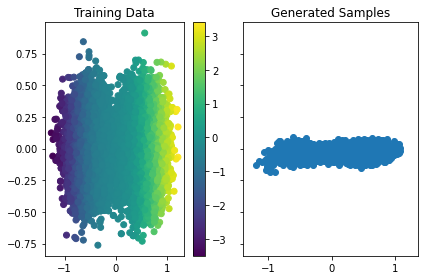

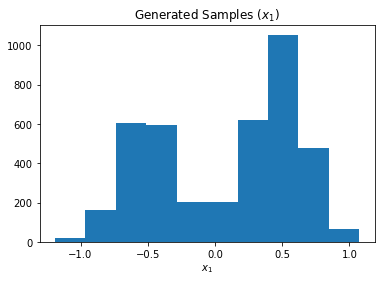

Epoch 20 Loss: -2001006058.3778727


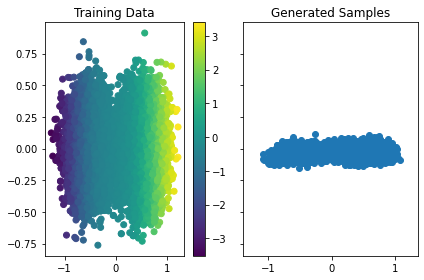

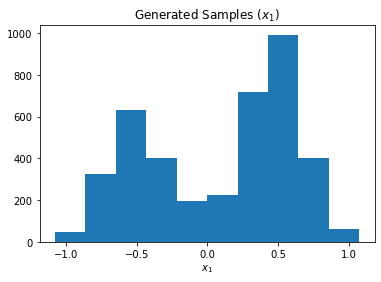

Epoch 21 Loss: -2001254530.2657669


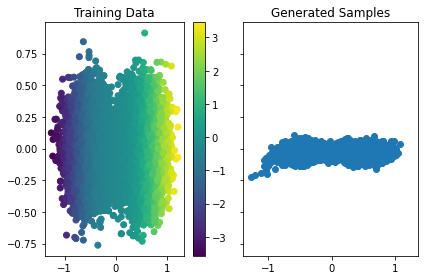

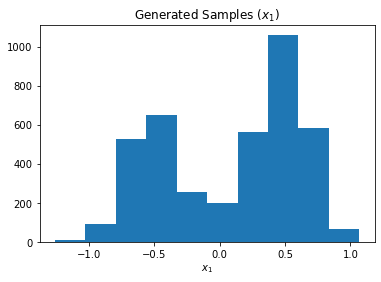

Epoch 22 Loss: -2001365353.6171637


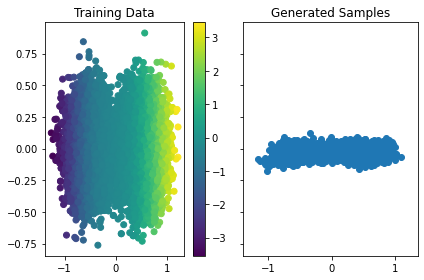

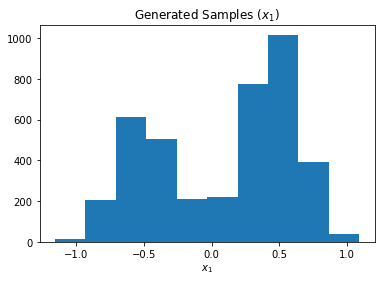

Epoch 23 Loss: -2002133024.3700233


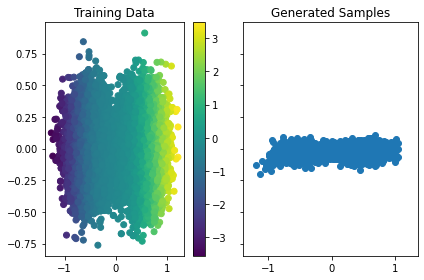

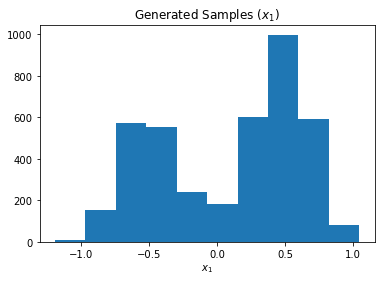

Epoch 24 Loss: -2001331897.6036065


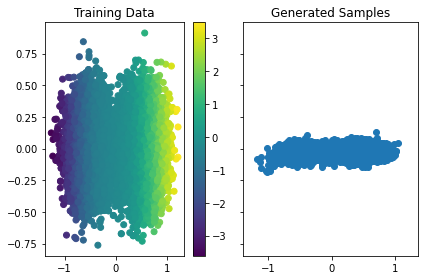

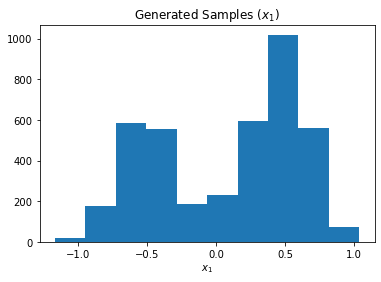

Epoch 25 Loss: -2001778008.9668992


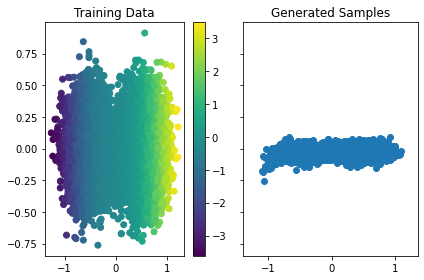

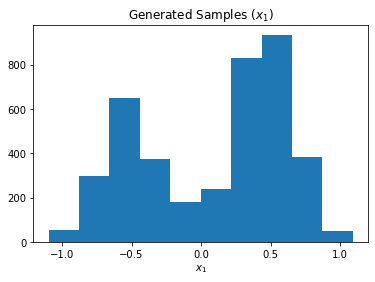

Epoch 26 Loss: -2002288713.7372868


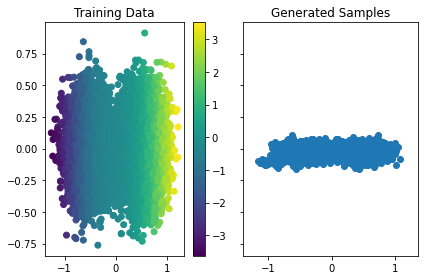

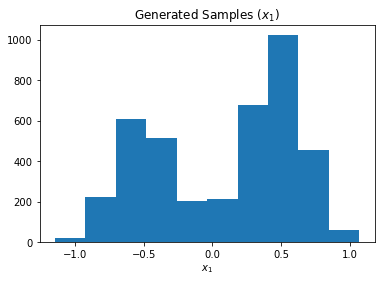

Epoch 27 Loss: -2002895208.7118204


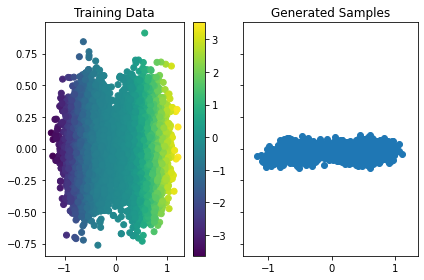

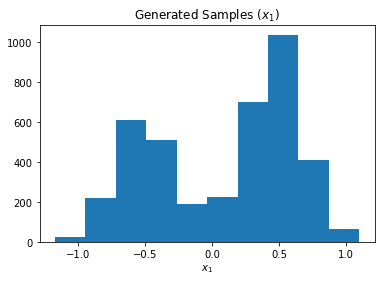

Epoch 28 Loss: -2002677971.6186285


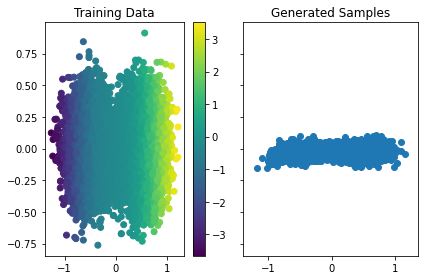

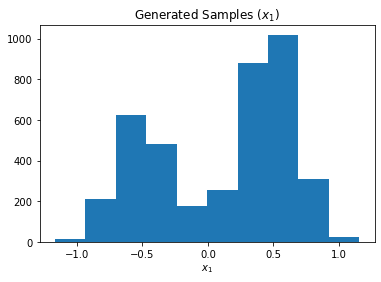

Epoch 29 Loss: -2003733527.4445746


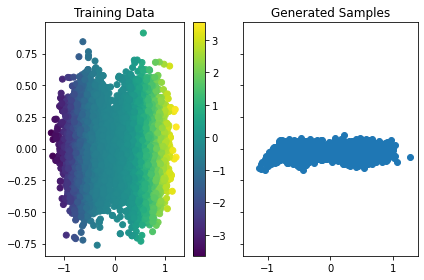

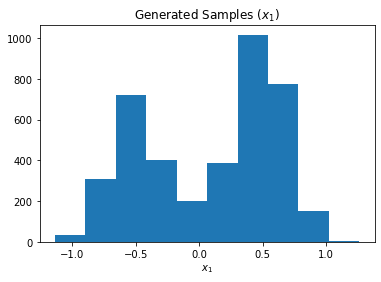

Epoch 30 Loss: -2002351156.304584


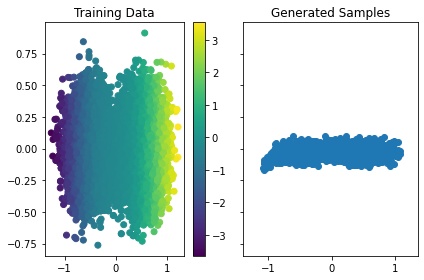

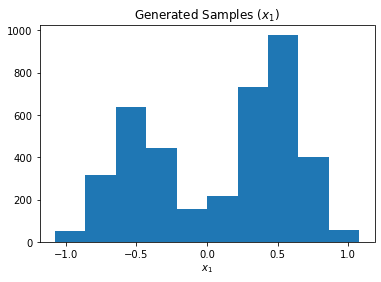

Epoch 31 Loss: -2003218940.981769


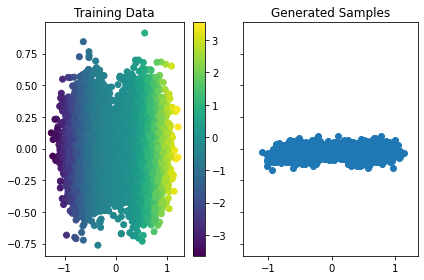

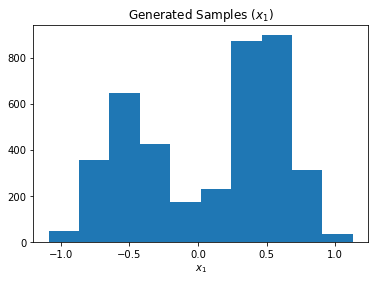

Epoch 32 Loss: -2002903778.8422089


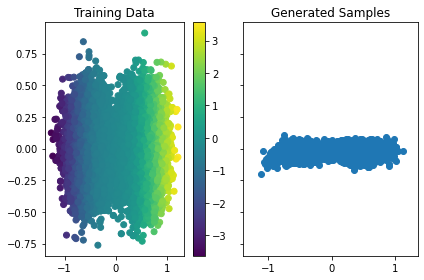

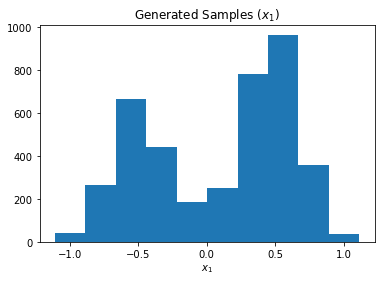

Epoch 33 Loss: -2003822097.8591578


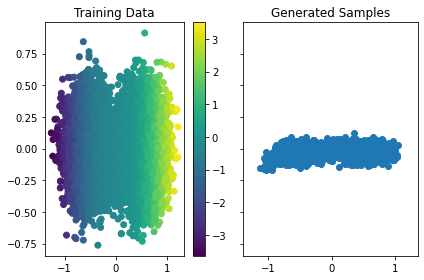

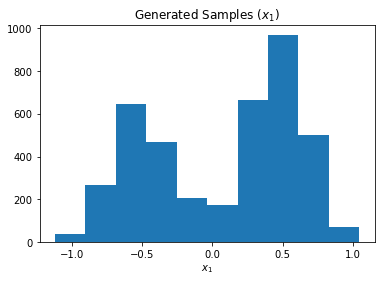

Epoch 34 Loss: -2003611588.1939883


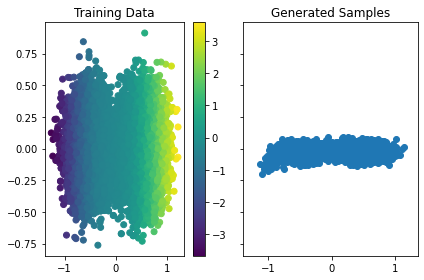

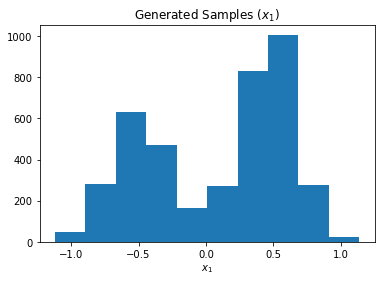

Epoch 35 Loss: -2004297468.4838428


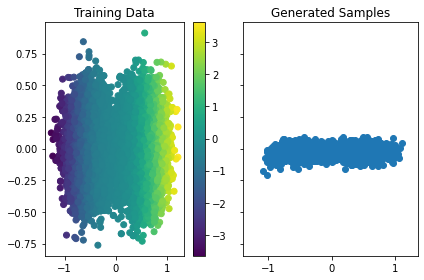

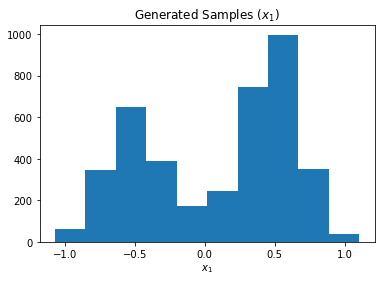

Epoch 36 Loss: -2003880824.6233993


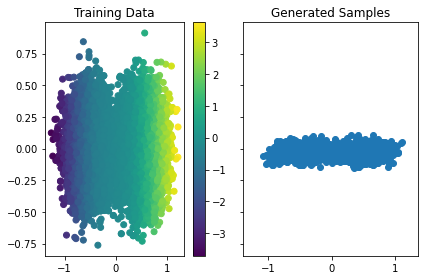

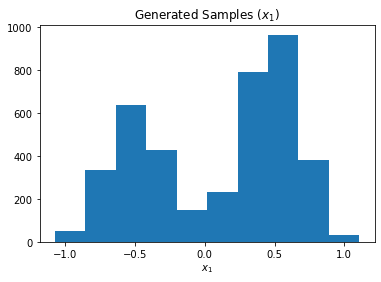

Epoch 37 Loss: -2004149595.0182626


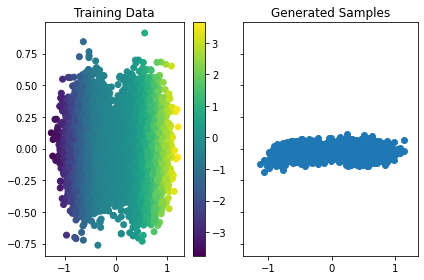

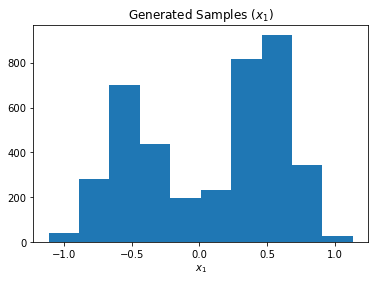

Epoch 38 Loss: -2003451882.688816


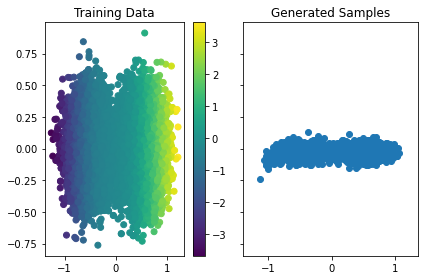

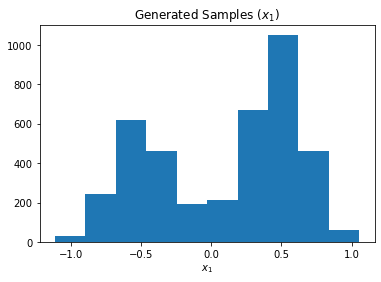

Epoch 39 Loss: -2004308485.17141


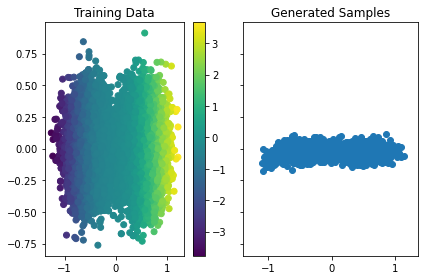

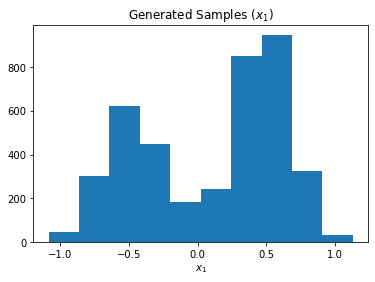

Epoch 40 Loss: -2003886362.8464816


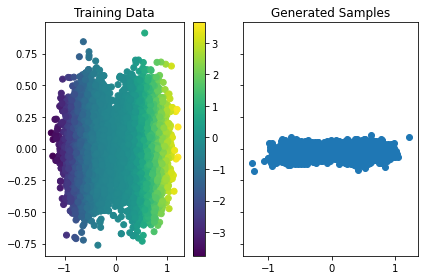

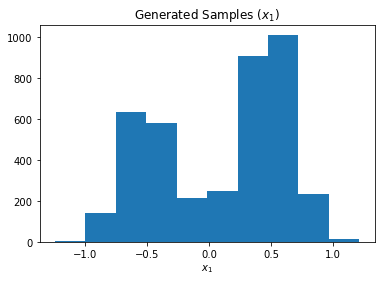

Epoch 41 Loss: -2004039547.3023057


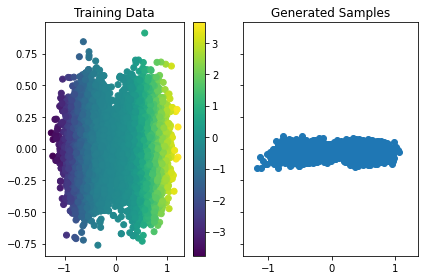

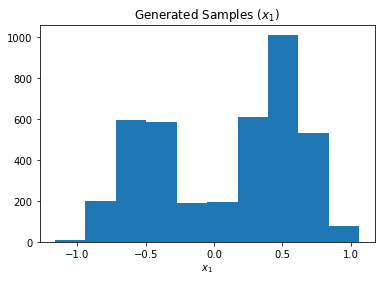

Epoch 42 Loss: -2005336887.951622


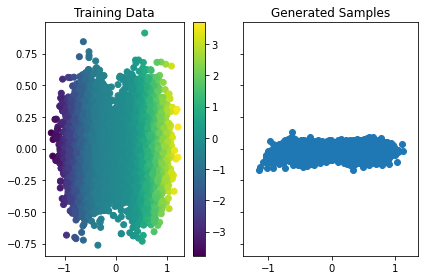

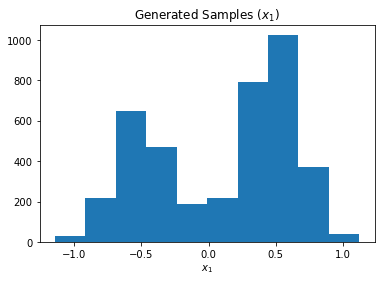

Epoch 43 Loss: -2004731432.4239945


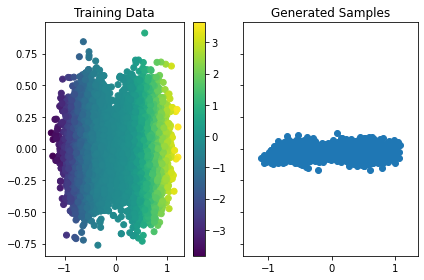

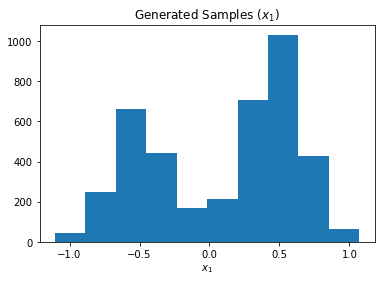

Epoch 44 Loss: -2004021079.3758423


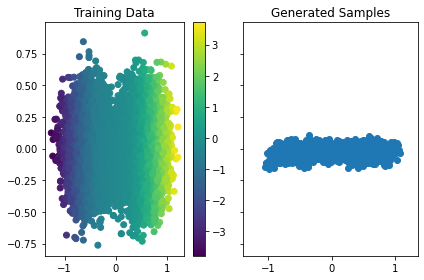

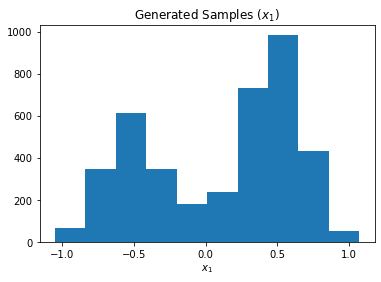

Epoch 45 Loss: -2004277529.9516253


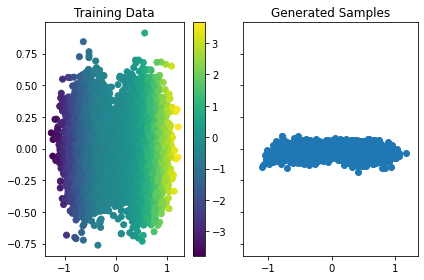

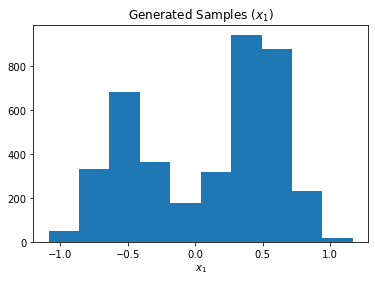

Epoch 46 Loss: -2004238075.9079652


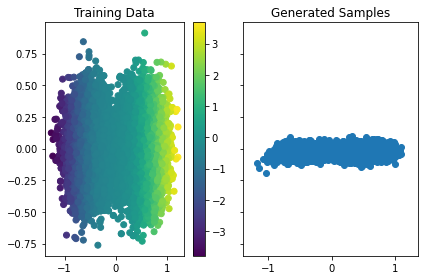

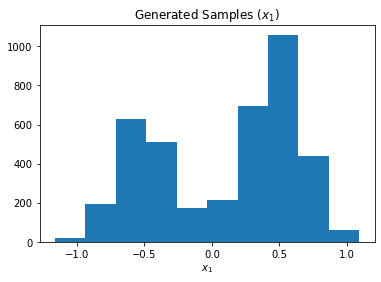

Epoch 47 Loss: -2004475159.6782072


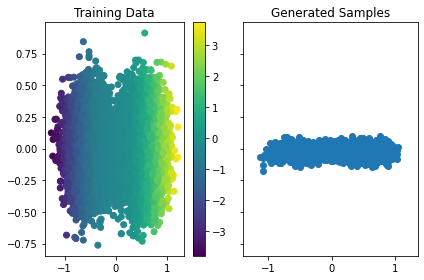

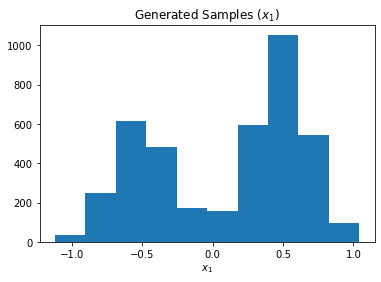

Epoch 48 Loss: -2004744930.7625844


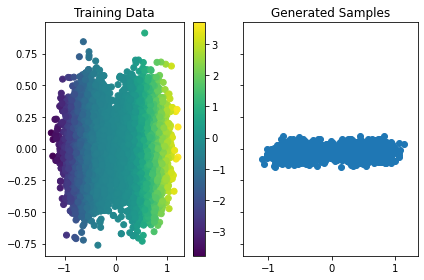

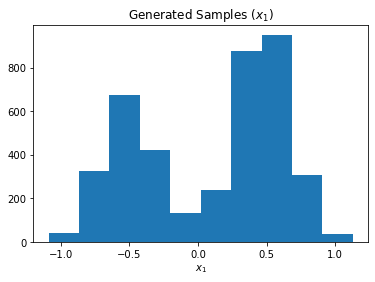

Epoch 49 Loss: -2004811097.5930297


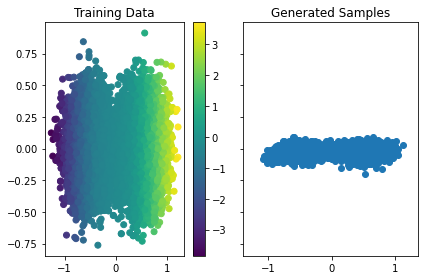

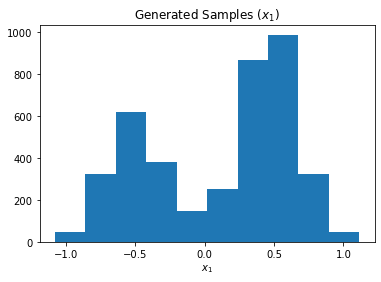

Epoch 50 Loss: -2004780602.54586


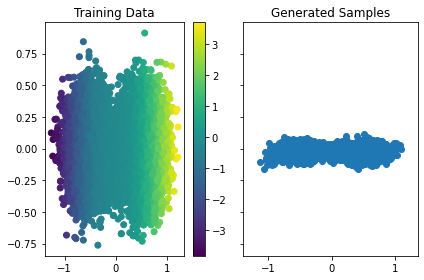

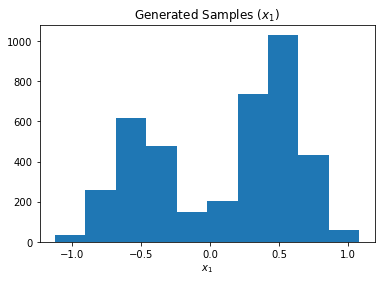

Epoch 51 Loss: -2004506349.1191504


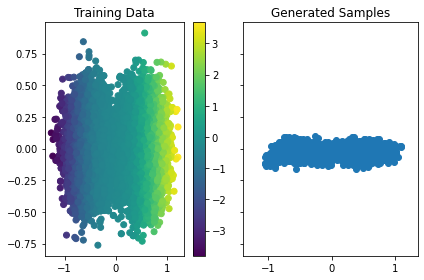

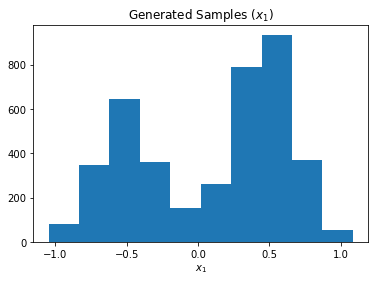

Epoch 52 Loss: -2005005848.2650783


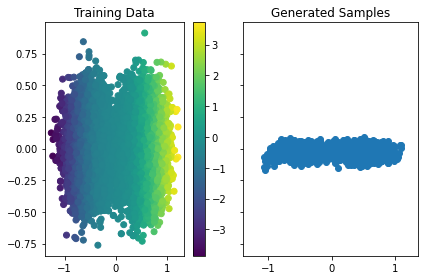

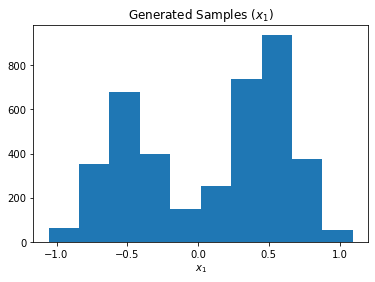

Epoch 53 Loss: -2005182437.0376637


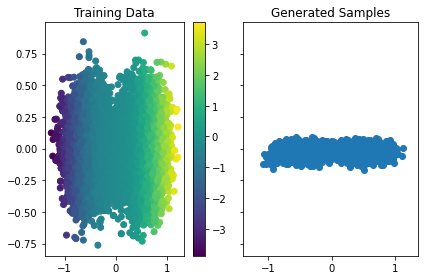

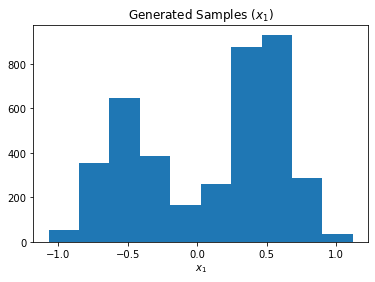

Epoch 54 Loss: -2004213475.8929427


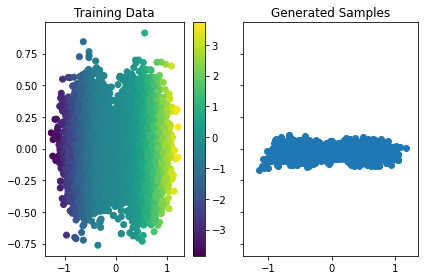

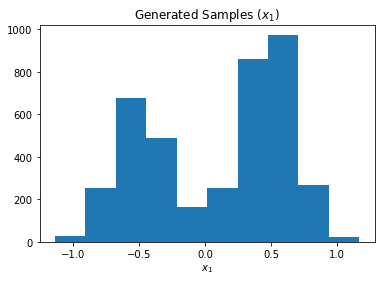

Epoch 55 Loss: -2005755317.7406733


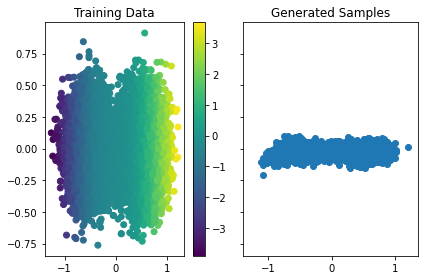

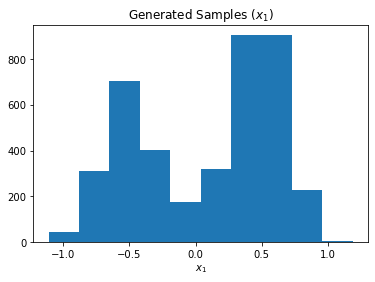

Epoch 56 Loss: -2005781041.7520964


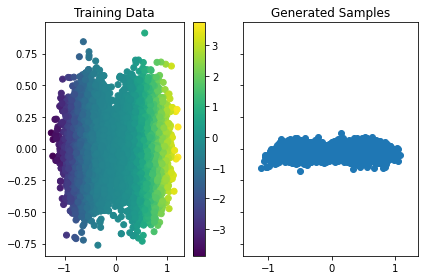

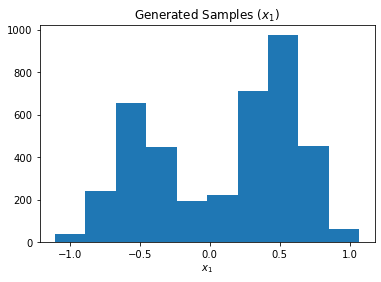

Epoch 57 Loss: -2004351206.4448273


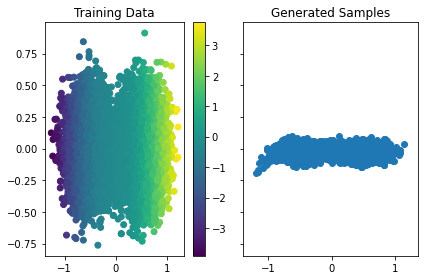

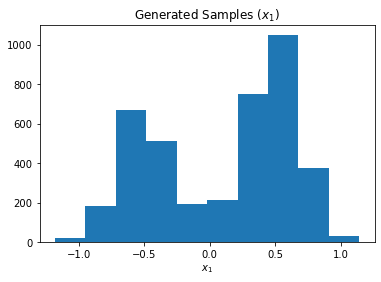

Epoch 58 Loss: -2004972700.017787


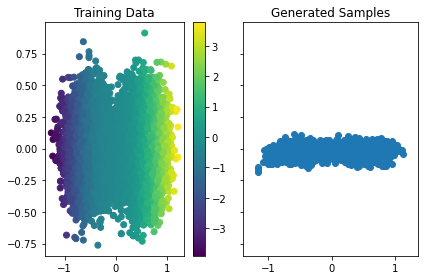

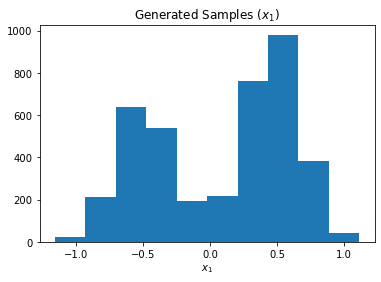

Epoch 59 Loss: -2005404541.018173


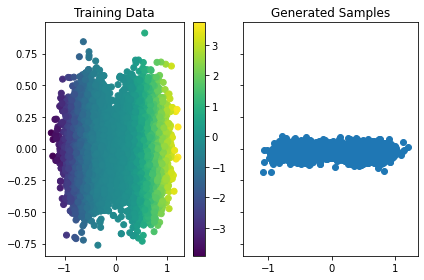

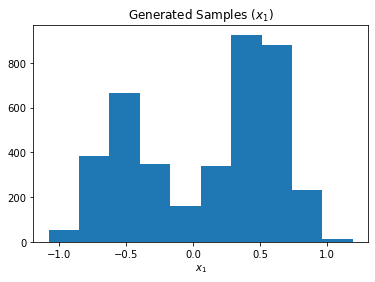

Epoch 60 Loss: -2005656985.709211


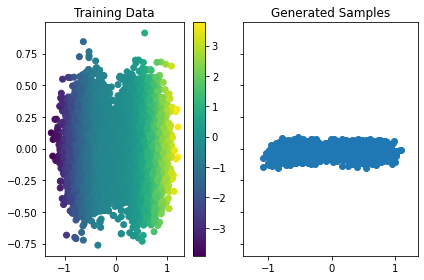

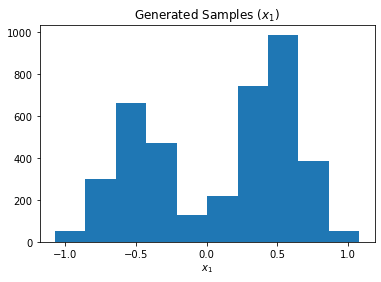

Epoch 61 Loss: -2005161011.670218


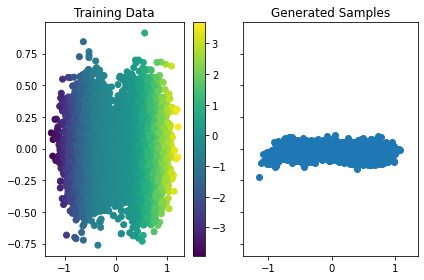

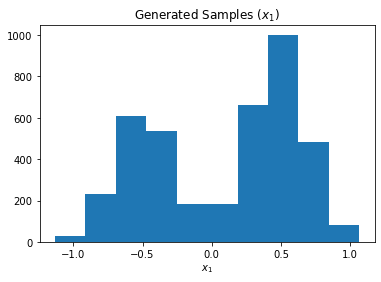

Epoch 62 Loss: -2004924059.4849682


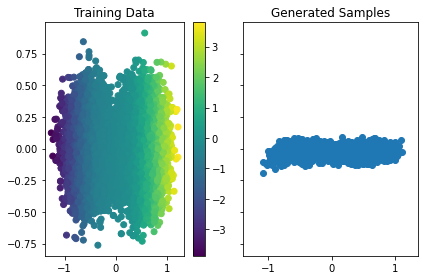

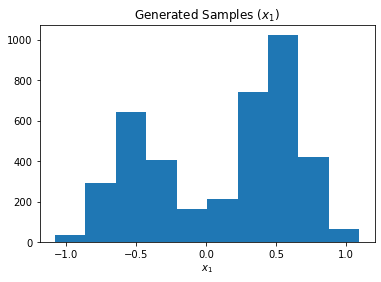

Epoch 63 Loss: -2005404432.0776997


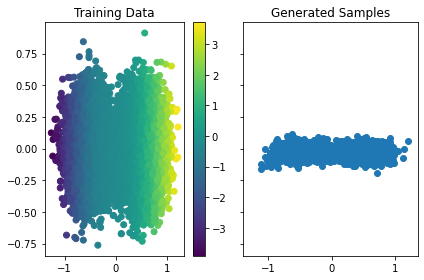

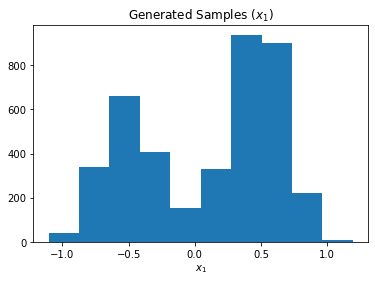

Epoch 64 Loss: -2006042998.0663726


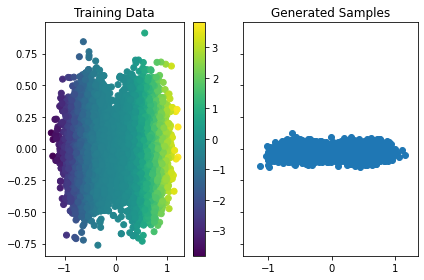

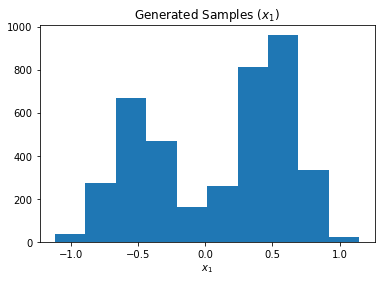

Epoch 65 Loss: -2005137047.5939054


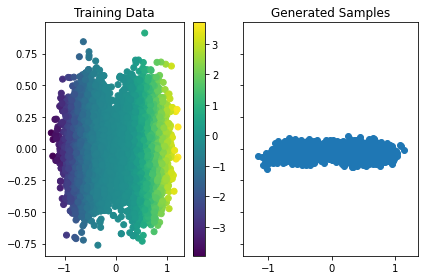

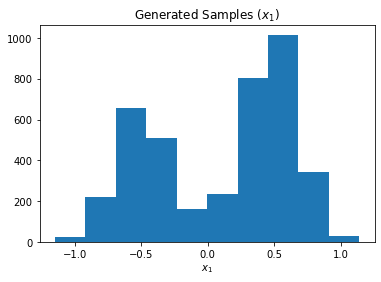

Epoch 66 Loss: -2005978422.5559473


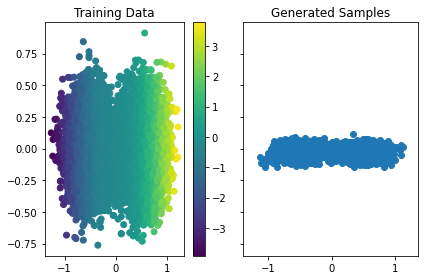

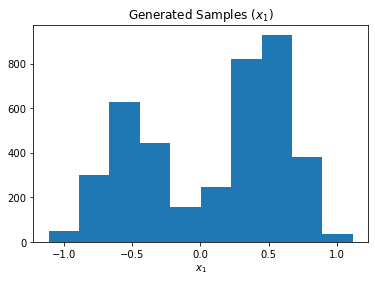

Epoch 67 Loss: -2006264331.8832574


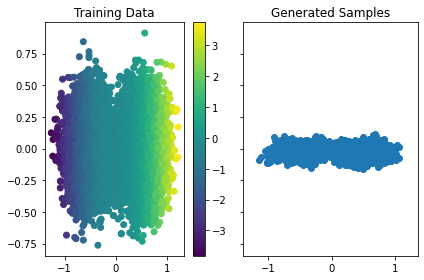

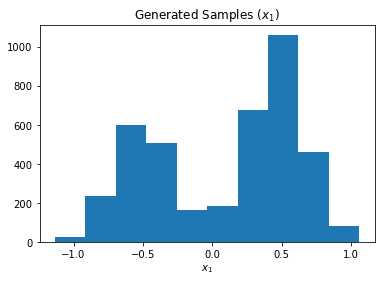

Epoch 68 Loss: -2005533729.9699395


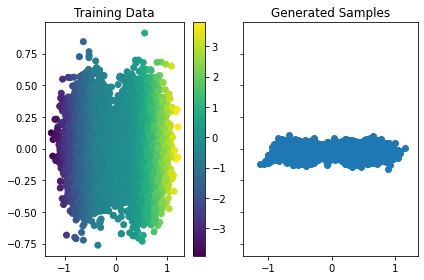

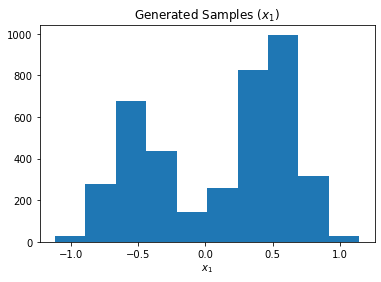

Epoch 69 Loss: -2006204241.0599475


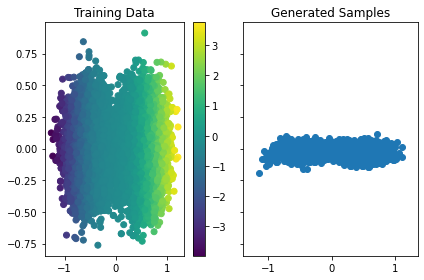

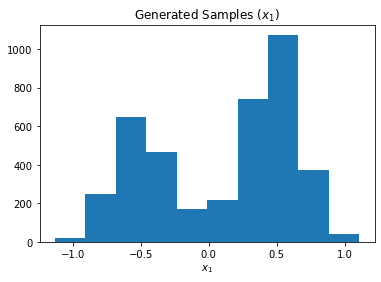

Epoch 70 Loss: -2005597663.3089135


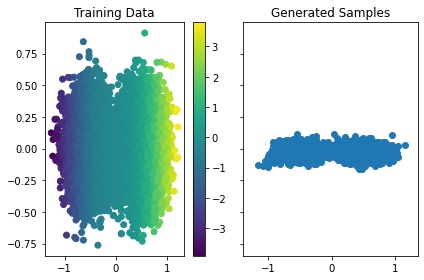

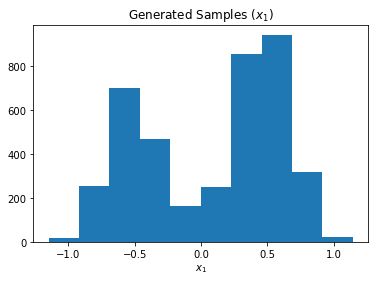

Epoch 71 Loss: -2005720092.2338884


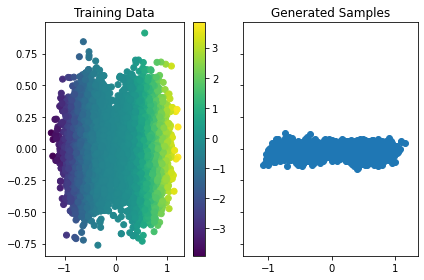

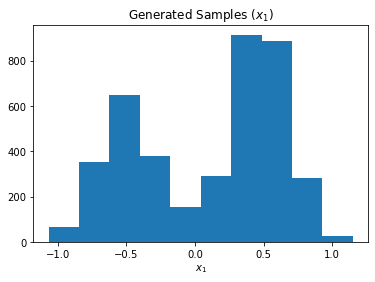

Epoch 72 Loss: -2005641129.082556


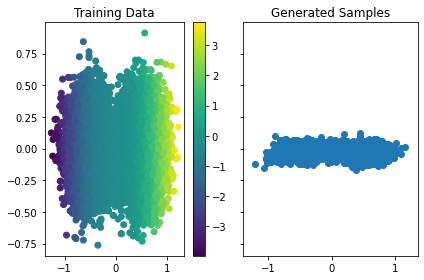

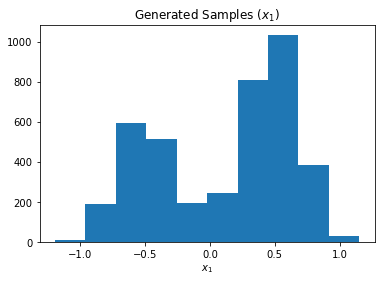

Epoch 73 Loss: -2005377026.0956714


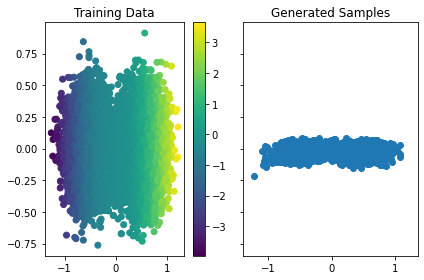

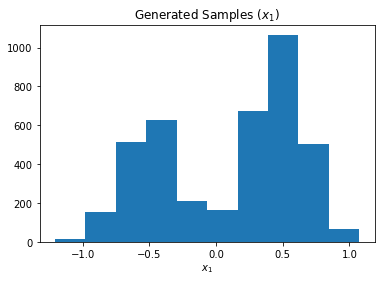

Epoch 74 Loss: -2005844659.5172737


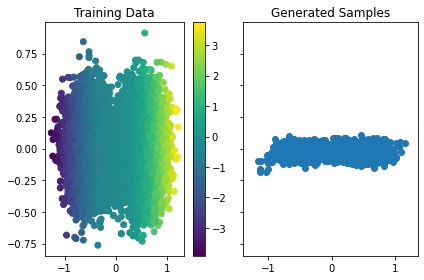

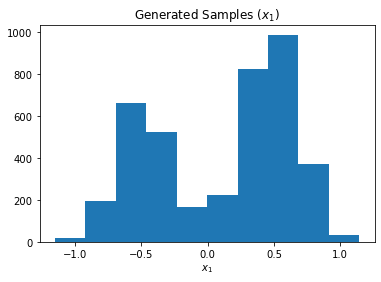

Epoch 75 Loss: -2006119613.2949314


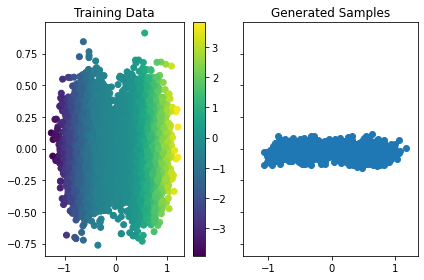

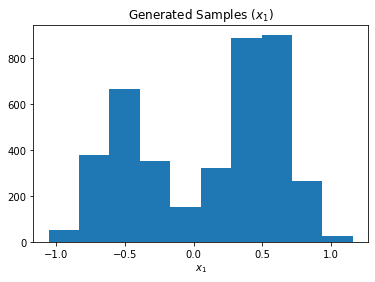

Epoch 76 Loss: -2005182884.463041


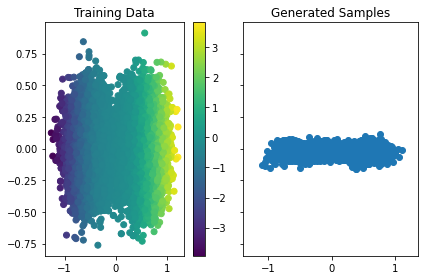

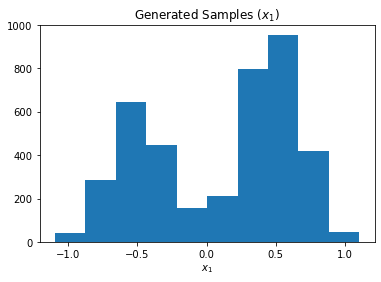

Epoch 77 Loss: -2005986184.8815773


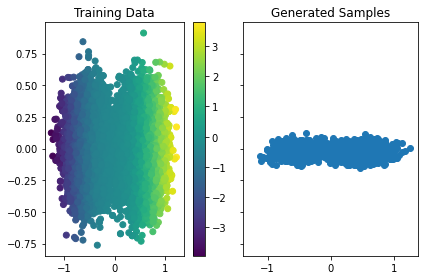

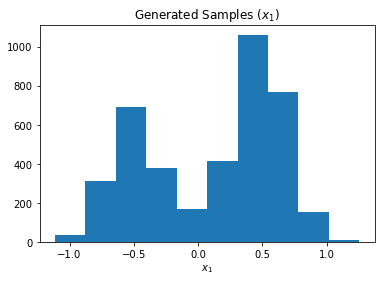

Epoch 78 Loss: -2005699607.2646403


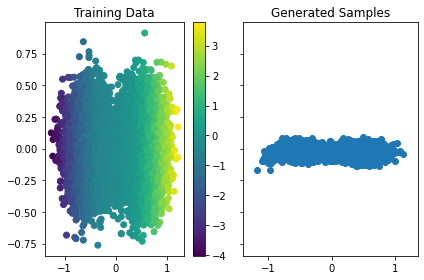

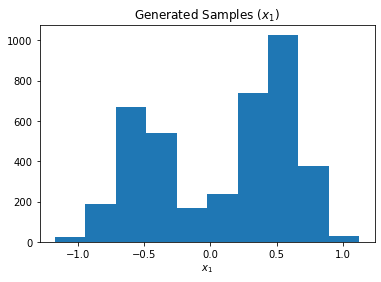

Epoch 79 Loss: -2006532565.1237261


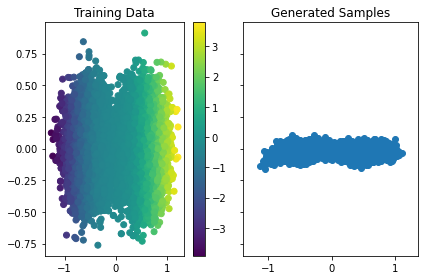

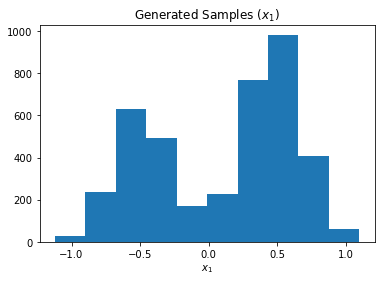

Epoch 80 Loss: -2005473329.8809013


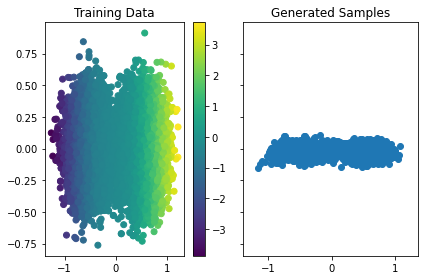

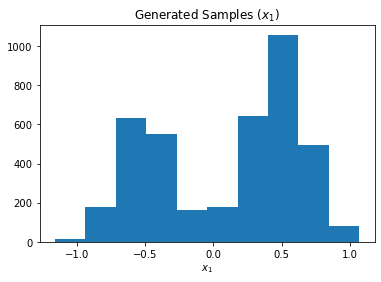

Epoch 81 Loss: -2006583787.8448858


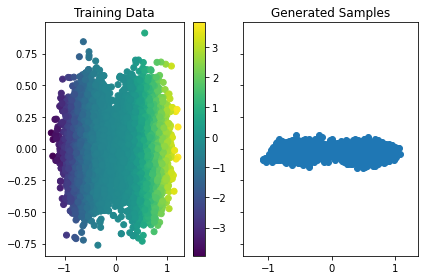

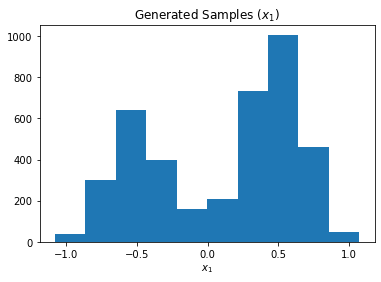

Epoch 82 Loss: -2005949761.5412424


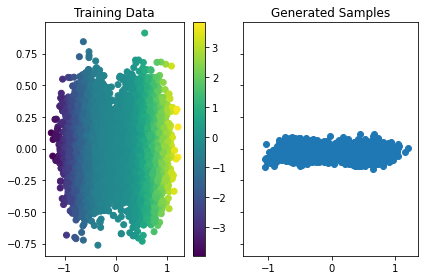

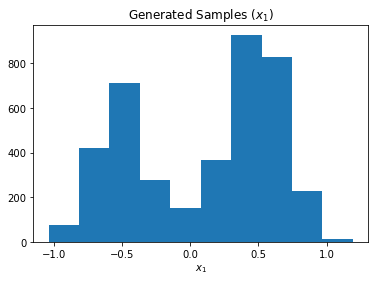

Epoch 83 Loss: -2005684556.26801


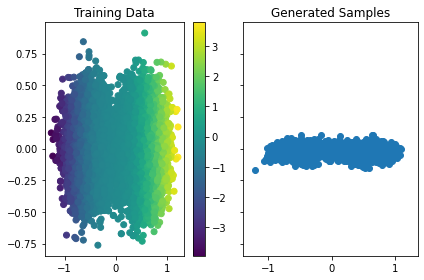

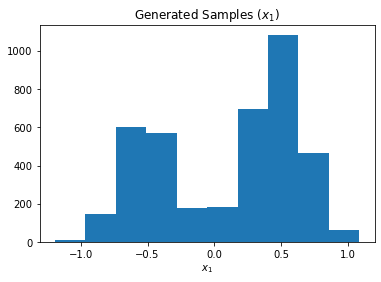

Epoch 84 Loss: -2006138627.528593


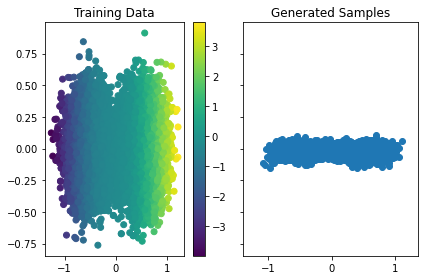

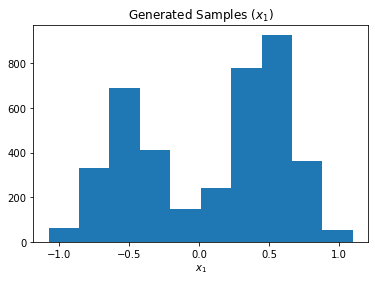

Epoch 85 Loss: -2006177055.5620196


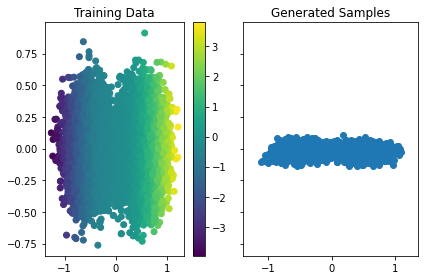

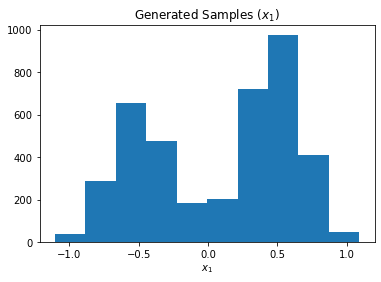

In [6]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mod = VAE().double()
mod = mod.to(device)
opt = torch.optim.Adam(mod.parameters(), lr = 1e-4,weight_decay = 1e-5)

# train
epochs = 85
L = 32 # number of monte carlo samples to estimate p(x | z) loss

for ep in range(epochs):
    mod.training = True
    train_loss = 0
    for batch_idx, data in enumerate(training_loader):
        
        # copy data to yield L monte carlo samples during forward pass
        dataaug = data[0].double().clone()
        for l in range(L - 1):
            dataaug = torch.cat((dataaug, data[0]), 0)
        data = torch.tensor(dataaug).to(device)
        
        opt.zero_grad()
        
        # forward pass
        recon_batch, mu_enc, logvar_enc = mod(data)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # backward pass
        loss = (N_train/batch_size)*VAEloss(mu_dec,logvar_dec,data,mu_enc,logvar_enc,L)
        loss.backward()
        opt.step()
        train_loss += loss.item()
        
    print("Epoch " + str(ep + 1) + " Loss: " + str(train_loss))
    
    # validation
    X_val = X_val.to(device)
    z = torch.randn(4000,1).double().to(device)
    with torch.no_grad():
        recon,mu_enc,_ = mod(X_val)
        mu_dec = recon[0]
        mu_gen,logvar_gen = mod.decode(z)
        x_gen = mu_gen + torch.exp(0.5*logvar_gen)*torch.randn(4000,2).double().to(device)
    
    X_np = X_val.cpu().numpy()
    mu_enc =  mu_enc.cpu().numpy()
    mu_dec = mu_dec.cpu().numpy()
    z = z.cpu().numpy().flatten()   
    x_gen = x_gen.cpu().numpy()
    
    fig, ax = plt.subplots(1,2,sharex = True, sharey = True)
    im1 = ax[0].scatter(X_np[:,0],X_np[:,1],c = mu_enc)
    ax[0].set_title('Training Data')
    fig.colorbar(im1,ax = ax[0])
    
    #ax[1].scatter(mu_dec[:,0],mu_dec[:,1])
    #ax[1].set_title('Reconstruction')
    ax[1].scatter(x_gen[:,0],x_gen[:,1])
    ax[1].set_title('Generated Samples')
    
    fig.tight_layout()
    plt.savefig('eq_data_vae'+str(ep+1)+'.png')
    plt.show()
    plt.close()
    
    plt.hist(x_gen[:,0])
    plt.title('Generated Samples ' + '$(x_1)$')
    plt.xlabel('$x_1$')
    plt.savefig('eq_data_vaex1'+str(ep+1)+'.png')
    plt.show()
    plt.close()